<a href="https://colab.research.google.com/github/ElhananElboher/siren/blob/dev/ex1_nueral_image_representation_using_sirens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implicit Neural Representations of Images (Using SIREN)**

I implemented the solution of this exerciese using the official implementation of the SIREN MLP, proposed in the paper: Implicit Neural Activations with Periodic Activation Functions (https://vsitzmann.github.io/siren).
 
# Execution Instructions

* Make sure that you have enabled the GPU under Edit -> Notebook Settings.

* Upload the exercise data images into two dedicated folders, one for the 48x48 images and the other for the 256x256 images (**Note:** The uploaded images are deleted at the end of each Google Colab's runtime session):


In [20]:
img_dir_48 = '/content/sample_data/data_48'
img_dir_256 = '/content/sample_data/data_256'

Here are some imports, and a utility function that quickly generates coordinate grids.

In [21]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import glob
import random

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


# The SIREN Model

Here is the author's implementation of the sine layer and the SIREN model. I use their implementation without any modifications.

In [22]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

<a id='section_1'></a>
## Question 1: Representing an Image Dataset

Given a dataset of  $n$  images, we are asked to build a network that can represnt the entire dataset. The solution expands the "simple example" given by Sitzmann et al. (Section 3.1 in their paper) from fitting a single image into fitting a set of  n  images.

We parametrize multiple RGB images $f_1(x) ... f_n(x)$ (where $f : ℝ^2 → ℝ^3$ map 2D pixel coordinates into 3D RGB values) by a SIREN  $Φ(x, i)$, where $i \in \{1...n\}$  is an image index.

In other words, we seek the function  $Φ$  such that the loss function $ L=∫Ω∥Φ(x, i)−f_i(x)∥dx $  is minimized, where $Ω$ is the domain of the entire dataset (i.e., all the possible combinations of spatial coordinates and image indexes).

Let's first write a dataset that consists of image indexes, per-pixel coordinates and corresponding RGB values (that is a modification of the author's dataset. I added some functionality also for the next questions):

In [23]:
class ImageFitting(Dataset):
    def __init__(self, 
                 sidelength, 
                 in_folder,
                 num_samples_per_image=0,
                 idx=-1):
        self.in_folder = in_folder
        self.sidelength = sidelength
        self.num_samples_per_image = num_samples_per_image
        self.sampled_coords_inds = None
        self.sampled_pixels_inds = None
        self.idx = idx
        super().__init__()
        
        self.pixels = None
        self.coords = None
        for idx, filename in enumerate(sorted(os.listdir(self.in_folder))):
            if self.idx > 0 and idx != self.idx:
                continue
            img = self.load_image(os.path.join(self.in_folder, filename))
            img = self.transform_image(img)
            img_pixels = img.permute(1, 2, 0).reshape(-1, 1)
            img_coords = get_mgrid(sidelength, 2)
            if self.num_samples_per_image > 0:
                sampled_coords_inds, sampled_pixels_inds = self.sample_coords()
                img_pixels = img_pixels[sampled_pixels_inds]
                img_coords = img_coords[sampled_coords_inds]
            img_inds = torch.tensor([idx] * len(img_coords))
            img_coords = torch.hstack((img_coords, torch.unsqueeze(img_inds, 1)))
            self.pixels = img_pixels if self.pixels is None else torch.cat((self.pixels, img_pixels), 0)
            self.coords = img_coords if self.coords is None else torch.cat((self.coords, img_coords), 0)
            

    def load_image(self, filename):
        img = Image.open(filename, 'r').convert('RGB')
        img = img.crop((0, 0, self.sidelength, self.sidelength))
        return img

    
    def sample_coords(self):
        sampled_coords_inds = sorted(random.sample(range(self.sidelength**2), self.num_samples_per_image))
        sampled_pixels_inds = []
        for i, sc in enumerate(sampled_coords_inds):
            sampled_pixels_inds.extend([3*sc, 3*sc+1, 3*sc+2])
        return sampled_coords_inds, sampled_pixels_inds


    def transform_image(self, img):
        transform = Compose([
            Resize(self.sidelength),
            ToTensor(),
            Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]), torch.Tensor([0.5]))
            ])
        t_img = transform(img)
        return t_img


    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: 
          raise IndexError  
        return self.coords, self.pixels

Let's instantiate the dataset and SIREN model. The model has three input features: two spatial coordinates and an image index, and three output channels that represent RGB values. 

For the internal network layers, I followed the authors' configuration for a single image and made no additional modifications.

In [24]:
img_dataset = ImageFitting(sidelength=48, in_folder=img_dir_48)
dataloader = DataLoader(img_dataset, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

No let's train the network on a dataset of $100$ RGB images of size $48$ x $48$, and tracks the reconstruction of three selected images at different stages of the training process.

[Note: Here we just demonstrate multiple images fitting. The generlization capability will be demonstrated by later sections.]

Step 0, Total loss 0.784577


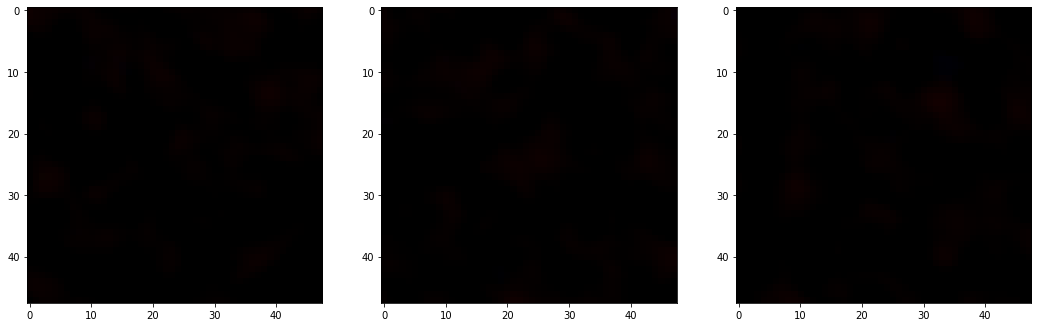

Step 400, Total loss 0.007453


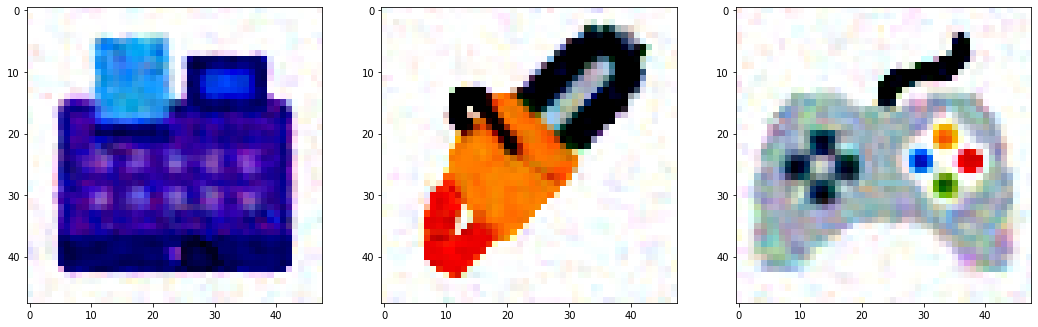

Step 800, Total loss 0.002898


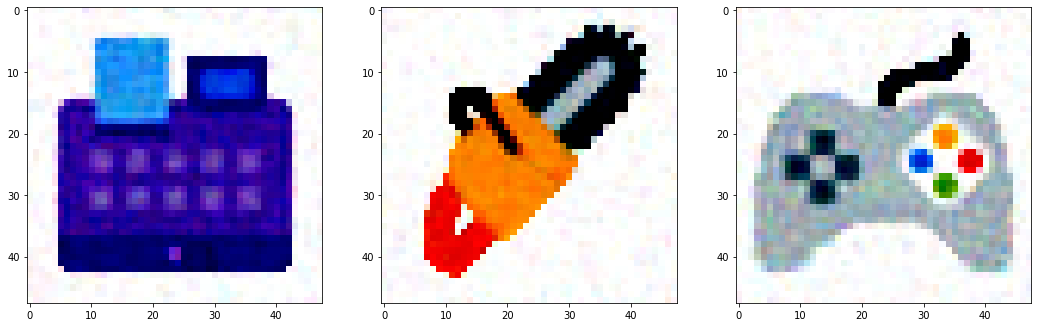

Step 1200, Total loss 0.001849


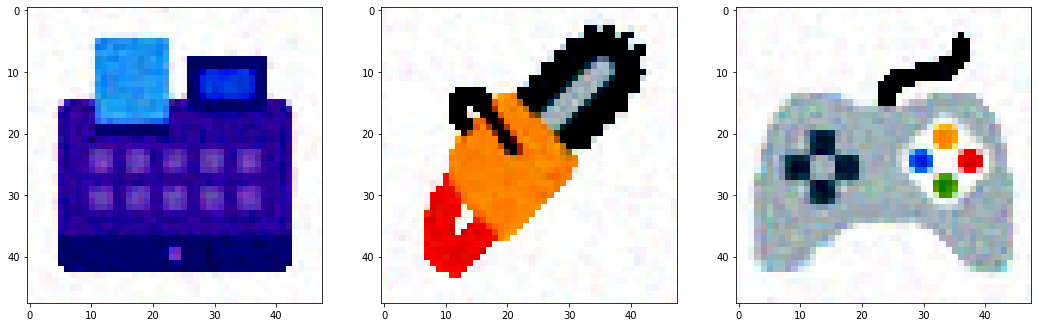

Step 1600, Total loss 0.001323


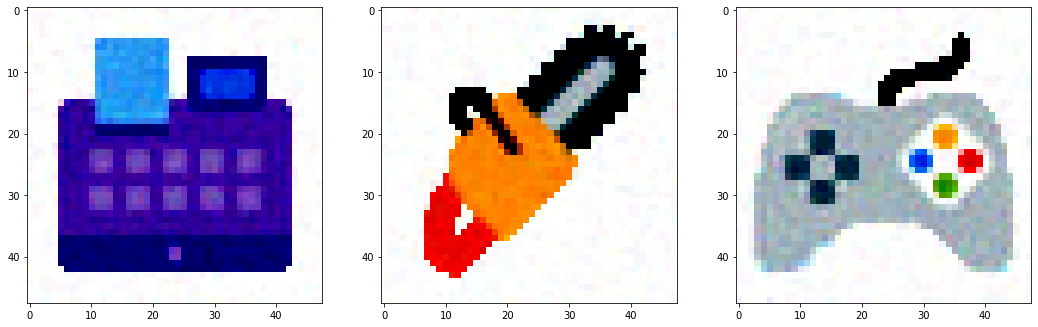

Step 2000, Total loss 0.001252


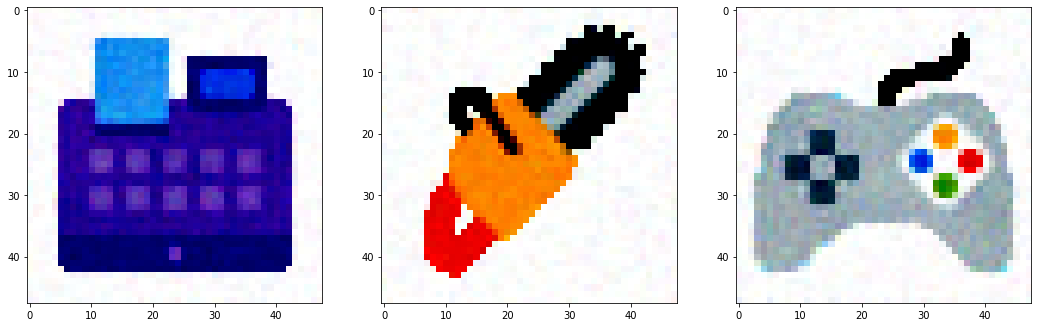

In [25]:
total_steps = 2001
steps_til_summary = 400

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)    
    loss = ((torch.flatten(model_output) - torch.flatten(ground_truth))**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        
        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output[:, (13*48*48):(14*48*48),:].cpu().view(48,48,3).detach().numpy().clip(0,1))
        axes[1].imshow(model_output[:, (15*48*48):(16*48*48),:].cpu().view(48,48,3).detach().numpy().clip(0,1))
        axes[2].imshow(model_output[:, (19*48*48):(20*48*48),:].cpu().view(48,48,3).detach().numpy().clip(0,1))
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

# Question 1(a): Generalization

Generalization is the ability to provide accurate predictions not only for the training samples, but also for any other sample in the domain. 

In this specific task, the meaning of generalization is the ability to learn a representation from $n$ subsets of image coordinates and corresponding RGB values, and provide accurate predictions for the RGB values of unseen image coordinates.

(Note: Unlike the case of consecutive video frames, here we assume that the content of each image is independent. Therefore it is irrelevant to predict the content of a image from other ones, and the training set must contain samples from all the $n$ images.)

The most basic kind of generalization is predicting all the images' RGB values based on random training samples, i.e., $n$ random subsets of spatial coordiantes and corresponding RGB values (such an experiment is described in the paper for the CelebA dataset, see Section 4.4 and Figure 6). **This kind of generalization is demonstrated below.**

Other kinds of generalizaion might include additional applications, e.g.:
* **Image inpainting**: Predict the RGB values of the unseen image parts after training over those of the visible parts.
* **Image rescaling**: Predict the RGB values in coordinates out of the regular grid of 48x48. That includes upsampling (which is demonstrated below in Question 2(a)), but also other geometric transformations such as changing the aspect ratio, etc.
* **Video frames interpolation**: In the special case of consecutive video frames, we might predict also fractional indexes and generate a slow-motion video.

# Generalization Example: Image Reconstruction Based on 30% Random Pixels

In the following, a SIREN model is trained by 30% random pixels from each image, and predicts the entire images' pixel values. We track the generalization and display the predictions of three selected images at differnt training stages. It can be seen that the generated images resemble the original ones, but the reconstructions are not very accurate as in the above example of image fitting (which is actually training over the entire dataset without generalization).

In [29]:
img_dataset_sampled = ImageFitting(sidelength=48, in_folder=img_dir_48, num_samples_per_image=int(0.3 * 48**2))
dataloader_sampled = DataLoader(img_dataset_sampled, batch_size=1, pin_memory=True, num_workers=0)

img_siren_sampled = Siren(in_features=3, out_features=3, hidden_features=256,
                          hidden_layers=3, outermost_linear=True)
img_siren_sampled.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

Step 0, Total loss 0.767232


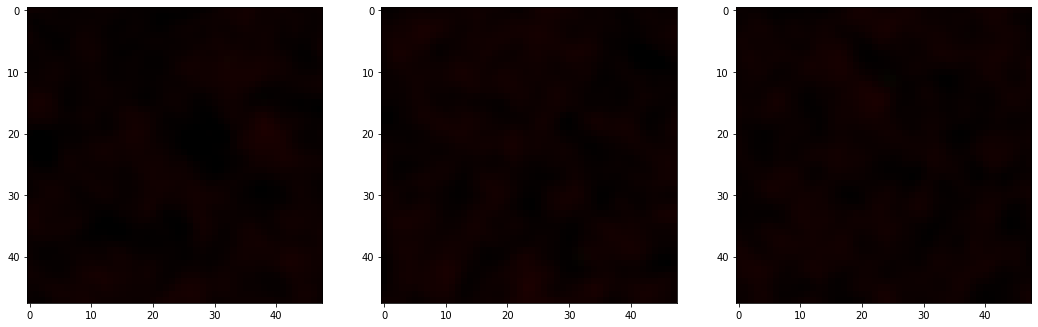

Step 400, Total loss 0.003428


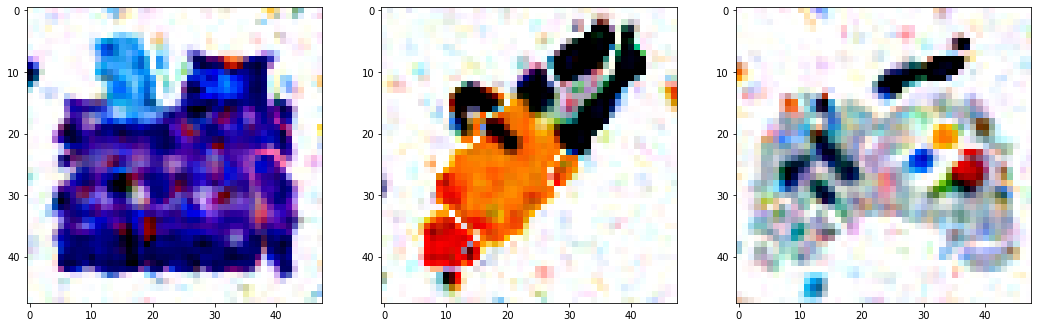

Step 800, Total loss 0.001055


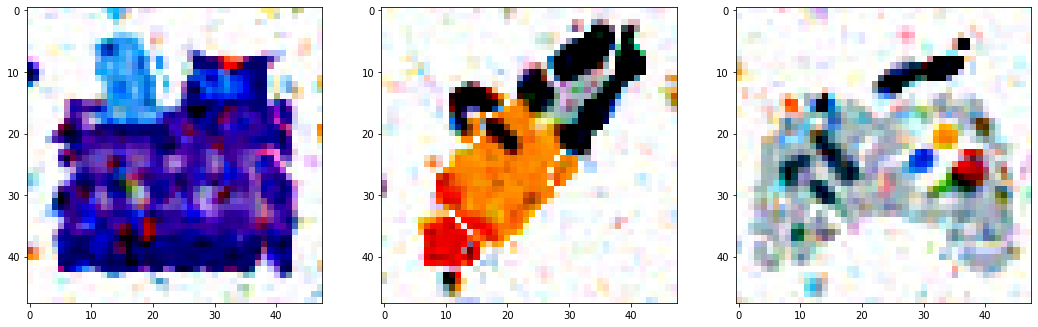

Step 1200, Total loss 0.000523


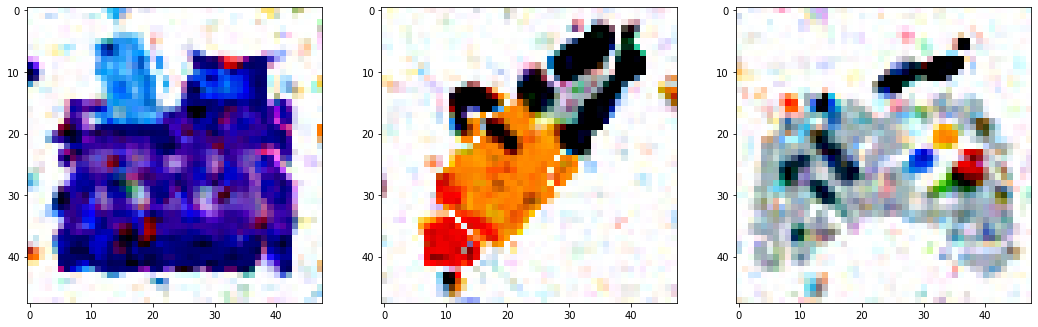

Step 1600, Total loss 0.000318


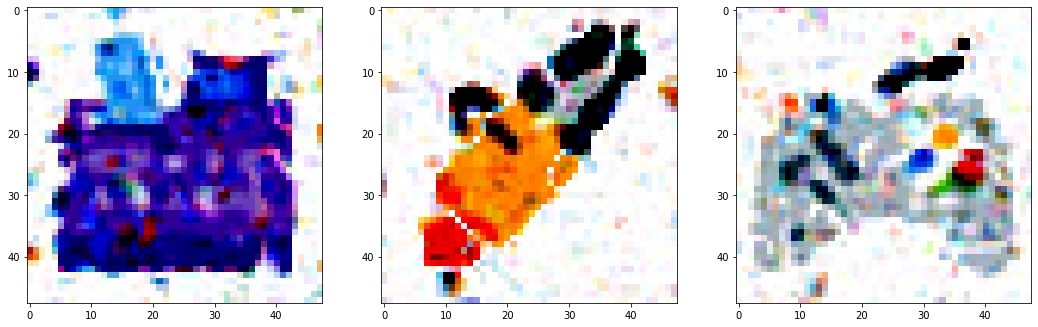

Step 2000, Total loss 0.000298


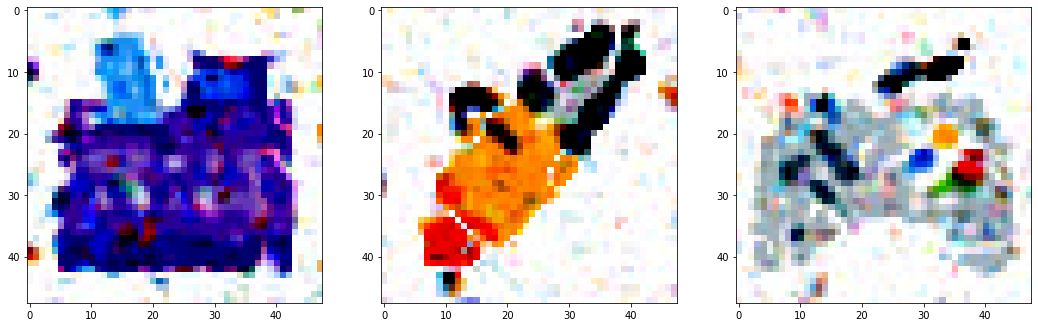

In [30]:
total_steps = 2001
steps_til_summary = 400

optim_s = torch.optim.Adam(lr=1e-4, params=img_siren_sampled.parameters())

model_input_sampled, ground_truth_sampled = next(iter(dataloader_sampled))
model_input_sampled, ground_truth_sampled = model_input_sampled.cuda(), ground_truth_sampled.cuda()

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output_sampled, coords_sampled = img_siren_sampled(model_input_sampled)    
    loss = ((torch.flatten(model_output_sampled) - torch.flatten(ground_truth_sampled))**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        with torch.no_grad():
            model_output, coords = img_siren_sampled(model_input)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output[:, (13*48*48):(14*48*48),:].cpu().view(48,48,3).detach().numpy().clip(0, 1))
        axes[1].imshow(model_output[:, (15*48*48):(16*48*48),:].cpu().view(48,48,3).detach().numpy().clip(0, 1))
        axes[2].imshow(model_output[:, (19*48*48):(20*48*48),:].cpu().view(48,48,3).detach().numpy().clip(0, 1))
        plt.show()

    optim_s.zero_grad()
    loss.backward()
    optim_s.step()

# Question 2(a): Image Upsampling

Upsampling the image does not require additional training, just applying the learned model for a grid of 256x256 coordinates. It is easy to obtain such a grid by creating an appropriate ImageFitting instance (i.e., with a specified grid size and a single image index).

Here is a demonstration for three image imdexes. We show the original 48x48 image (right), the upsampled image (middle) and the ground-truth 256x256 image. It can be seen that the upsampled images are not pixelized as the original 48x48 images, and their edges are not very smoothed. Of course, the upsampled images' quality is significantly lower than the ground-truth 256x256 images.

Image 92, MSE 0.067049


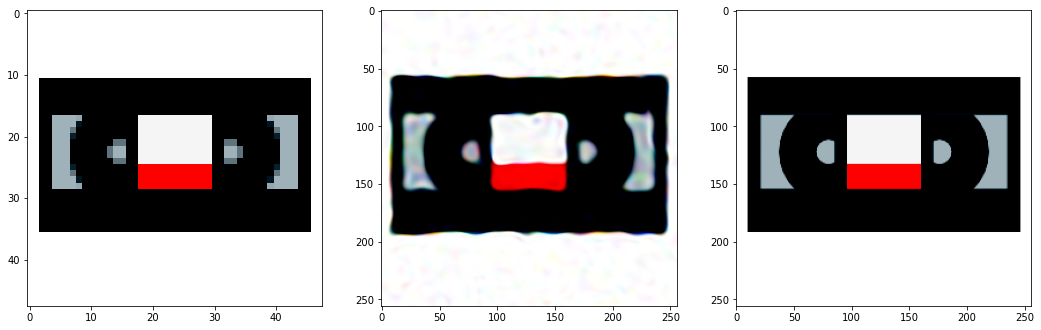

Image 7, MSE 0.067049


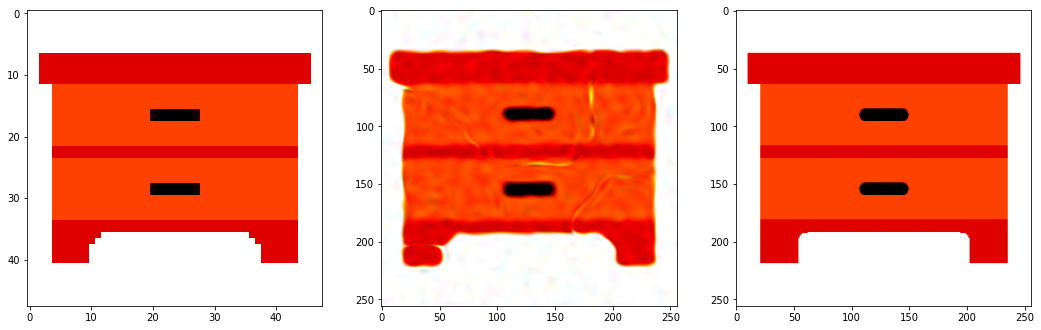

Image 3, MSE 0.067049


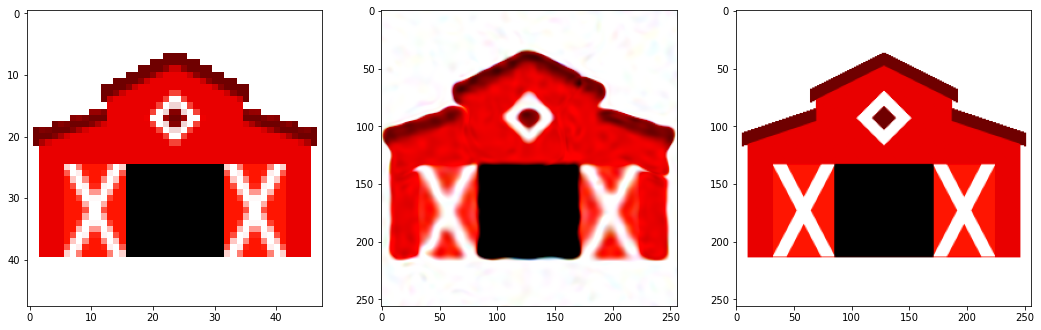

In [31]:
for single_img_idx in [92, 7, 3]:

    img_dataset_large = ImageFitting(sidelength=256, in_folder=img_dir_256, idx=single_img_idx)
    dataloader_large = DataLoader(img_dataset_large, batch_size=1, pin_memory=True, num_workers=0)

    model_input_large, ground_truth_large = next(iter(dataloader_large))
    model_input_large, ground_truth_large = model_input_large.cuda(), ground_truth_large.cuda()

    model_output_large, coords_large = img_siren(model_input_large)    
    mean_sqr_err = ((torch.flatten(model_output) - torch.flatten(ground_truth))**2).mean()
        
    print("Image %d, MSE %0.6f" % (single_img_idx, mean_sqr_err))

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow(ground_truth[:, (single_img_idx*48*48*3):((single_img_idx+1)*48*48*3),:].cpu().view(48,48,3).detach().numpy().clip(0, 1))
    axes[1].imshow(model_output_large.cpu().view(256,256,3).detach().numpy().clip(0, 1))
    axes[2].imshow(ground_truth_large.cpu().view(256,256,3).detach().numpy().clip(0, 1))
    plt.show()




# Question 2(b): Generate new images

In that question we are required to generate a new image by an interpolation of two existing images (or, more precisely, by interpolating the **representations** of two images). The proposed solution follows the Poisson image editing method described by Sitzmann et al. (Section 4.1 + Figure 3).

The seclected representation is the image gradient $ \nabla f(x) $, and the similarity measure is the (minus) mean squared error between the values of two gradient maps. 

Here is the algorithm descrption:

* Given two images $f_1(x), f_2(x)$ we construct the gradient maps $\nabla f_1(x), \nabla f_2(x)$ by computing their partial rows and columns derivatives (see the fucntion calc_grads). 

* Create a new representation by summing the gradient maps: $\nabla f_{GT}(x) = \nabla f_1(x) + \nabla f_2(x)$

* Train a SIREN model with a 2D input feature (just spatial coordiantes, no image index is required) and a 3D output feature that represents the generated RGB values. In each iteration, apply a forward pass for all the spatial coordinates, and construct the gradient map of the resulting image, $\nabla f_{SIREN}(x)$. 

* The training objective is minimizing the MSE between the "ground truth" graient map and the gradient map of SIREN's prediction: $|| \nabla f_{SIREN}(x) - f_{GT}(x) ||$ .

Since the gradient map of the generated image approaches the sum of the gradient maps of the original images $f_1(x)$ and $f_2(x)$, the generated image itself has a structure that mixes structural motives from both images.

The code below implements the generation of such a mixed image by interpolation of two 256x256 images. We display the original images, the interpolated image, the sum of gradient maps $\nabla f_{GT}(x)$ and the graident map of the interpolated image $\nabla f_{SIREN}(x)$.

First, let's implement an auxiliary function for gradient map calculation, and another function that loads an image pair and performs interpolation (or mixing):

In [32]:
def calc_grad(img):
    grad_img_x = img.view(256,256,3)[:-2, :-2, :] - img.view(256,256,3)[2:, :-2, :]
    grad_img_y = img.view(256,256,3)[:-2, :-2, :] - img.view(256,256,3)[:-2, 2:, :]
    grad_img = torch.hstack((grad_img_x, grad_img_y))
    return grad_img


def mix_image_pair(ind_a, ind_b, total_steps, steps_til_summary):
    img_dataset_a = ImageFitting(sidelength=256, in_folder=img_dir_256, idx=ind_a)
    dataloader_a = DataLoader(img_dataset_a, batch_size=1, pin_memory=True, num_workers=0)

    img_dataset_b = ImageFitting(sidelength=256, in_folder=img_dir_256, idx=ind_b)
    dataloader_b = DataLoader(img_dataset_b, batch_size=1, pin_memory=True, num_workers=0)

    img_siren_mix = Siren(in_features=2, out_features=3, hidden_features=256,
                          hidden_layers=3, outermost_linear=True)
    img_siren_mix.cuda()

    optim = torch.optim.Adam(lr=1e-4, params=img_siren_mix.parameters())

    model_input_a, ground_truth_a = next(iter(dataloader_a))
    model_input_a, ground_truth_a = model_input_a.cuda(), ground_truth_a.cuda()

    model_input_b, ground_truth_b = next(iter(dataloader_b))
    model_input_b, ground_truth_b = model_input_b.cuda(), ground_truth_b.cuda()

    grad_a = calc_grad(ground_truth_a)
    grad_b = calc_grad(ground_truth_b)
    grad_gt = grad_a + grad_b

    for step in range(total_steps):
        img_grid = model_input_a[:, :, :2]   # image coordinates; the index is not required in that task
        model_output_mix, _ = img_siren_mix(img_grid)

        img_grad_mix = calc_grad(model_output_mix)
        
        loss = ((torch.flatten(img_grad_mix) - torch.flatten(grad_gt))**2).mean()
        
        if step != 0 and not step % steps_til_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))

            fig, axes = plt.subplots(2,3, figsize=(18,12))
            axes[1,0].imshow(img_grad_mix.view(254,254*2,3).cpu().detach().numpy().clip(0, 1))
            axes[1,1].imshow(grad_gt.view(254,254*2,3).cpu().detach().numpy().clip(0, 1))
            axes[0,0].imshow(ground_truth_a.view(256,256,3).cpu().detach().numpy().clip(0, 1))
            axes[0,1].imshow(ground_truth_b.view(256,256,3).cpu().detach().numpy().clip(0, 1))
            axes[0,2].imshow(model_output_mix.view(256,256,3).cpu().detach().numpy().clip(0, 1))
            plt.show()

        optim.zero_grad()
        loss.backward()
        optim.step()


Here are three examples of mixing pairs of images:

Step 100, Total loss 0.001863


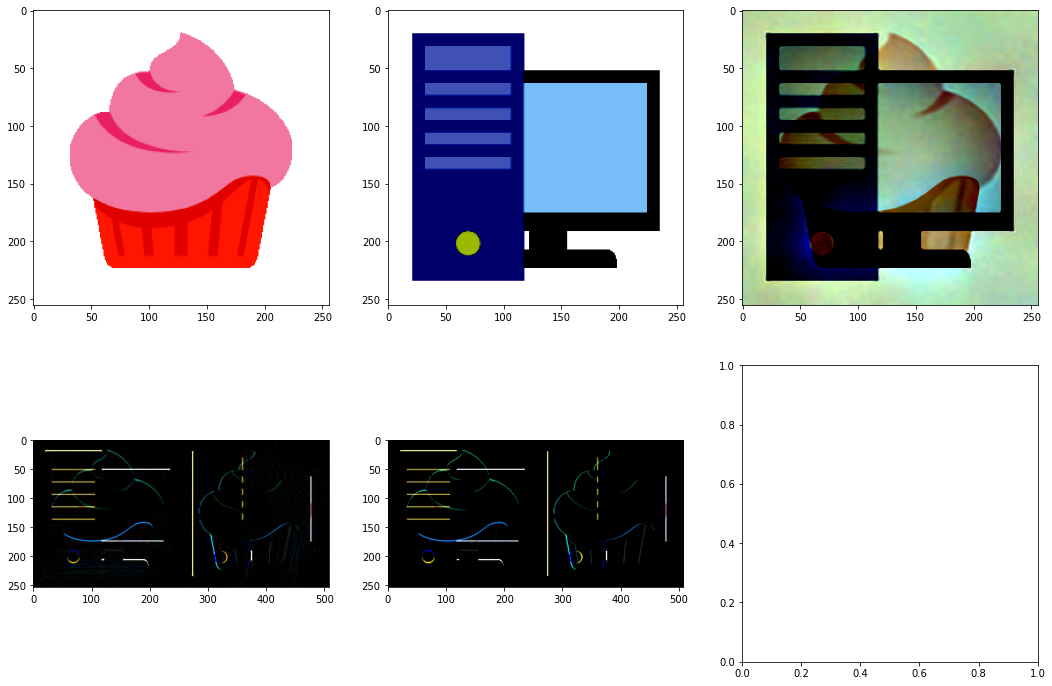

Step 200, Total loss 0.000558


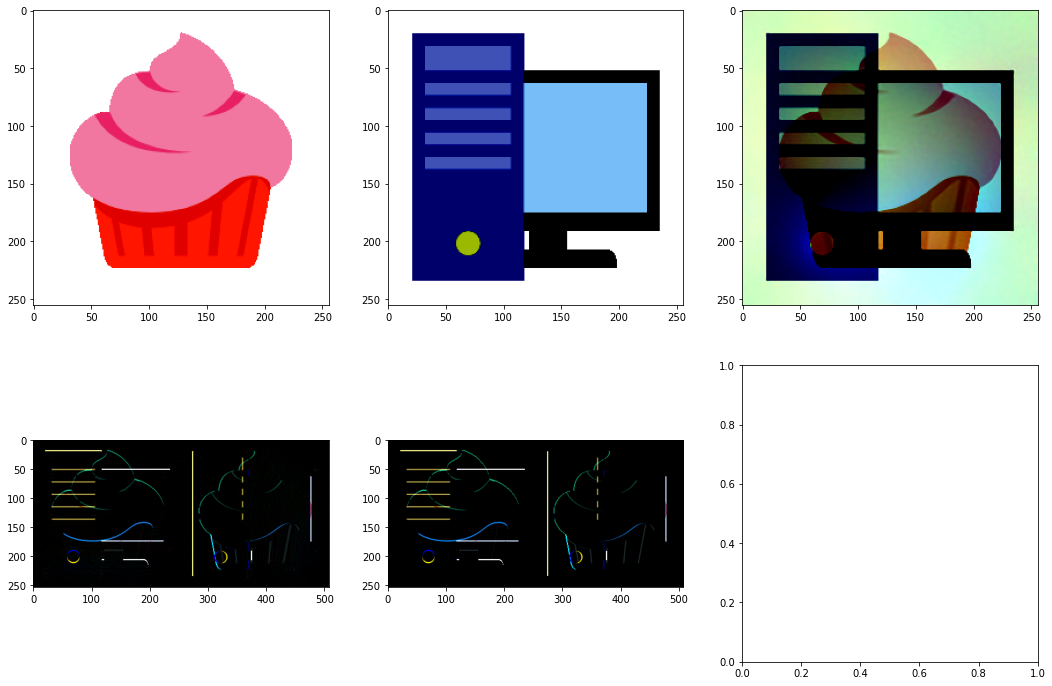

Step 300, Total loss 0.000276


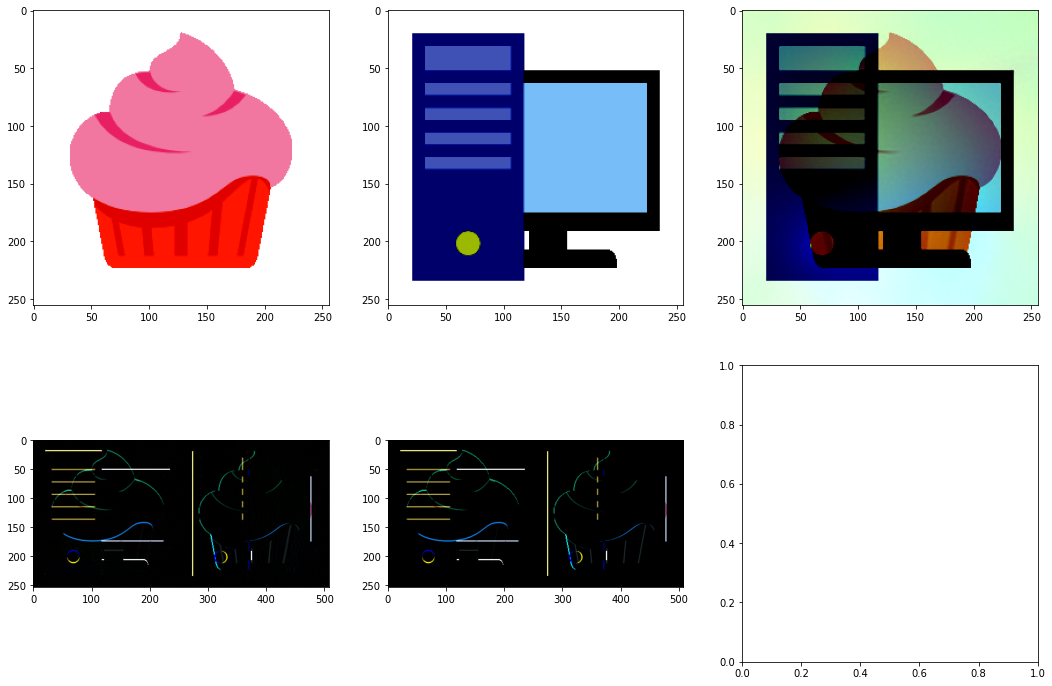

Step 400, Total loss 0.000207


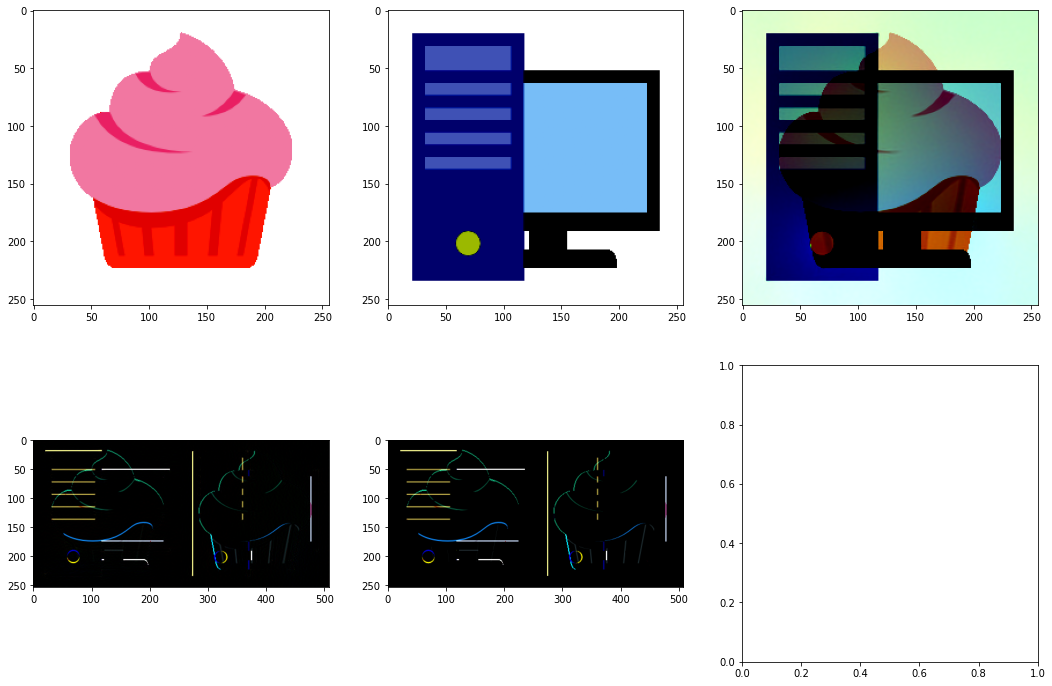

Step 500, Total loss 0.000104


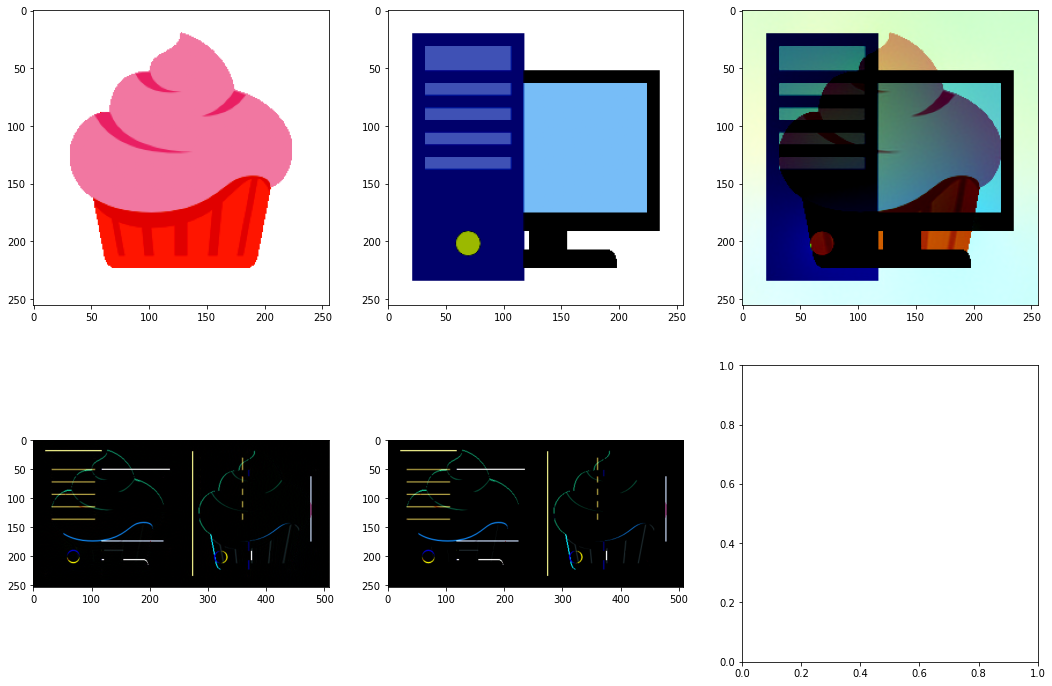

In [33]:
mix_image_pair(18, 99, total_steps=501, steps_til_summary=100)

Step 100, Total loss 0.007030


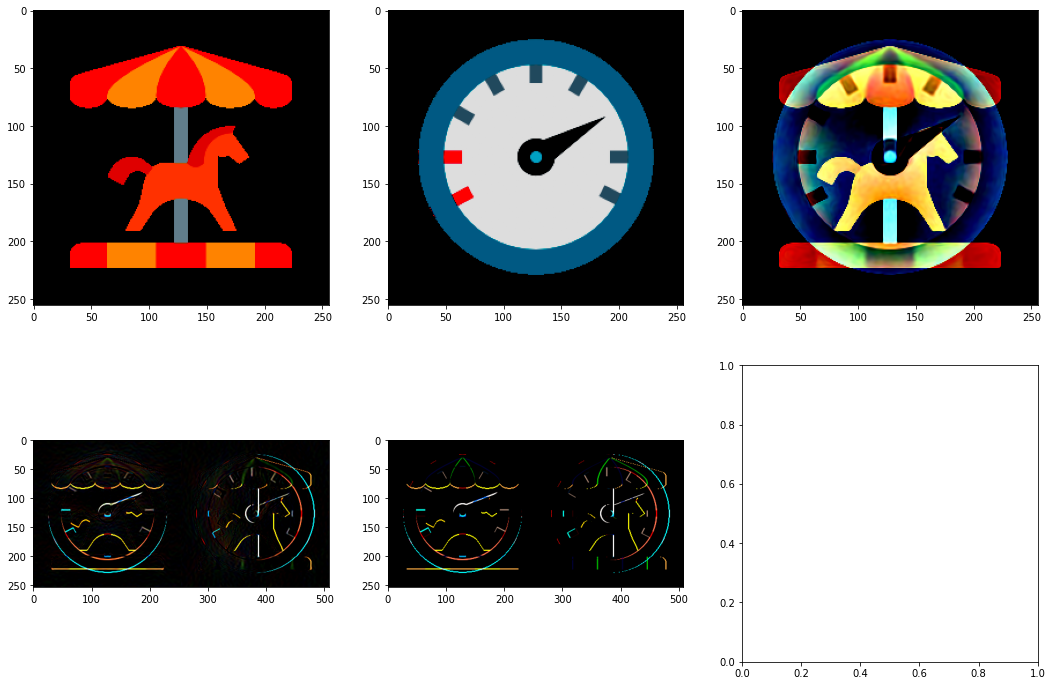

Step 200, Total loss 0.002266


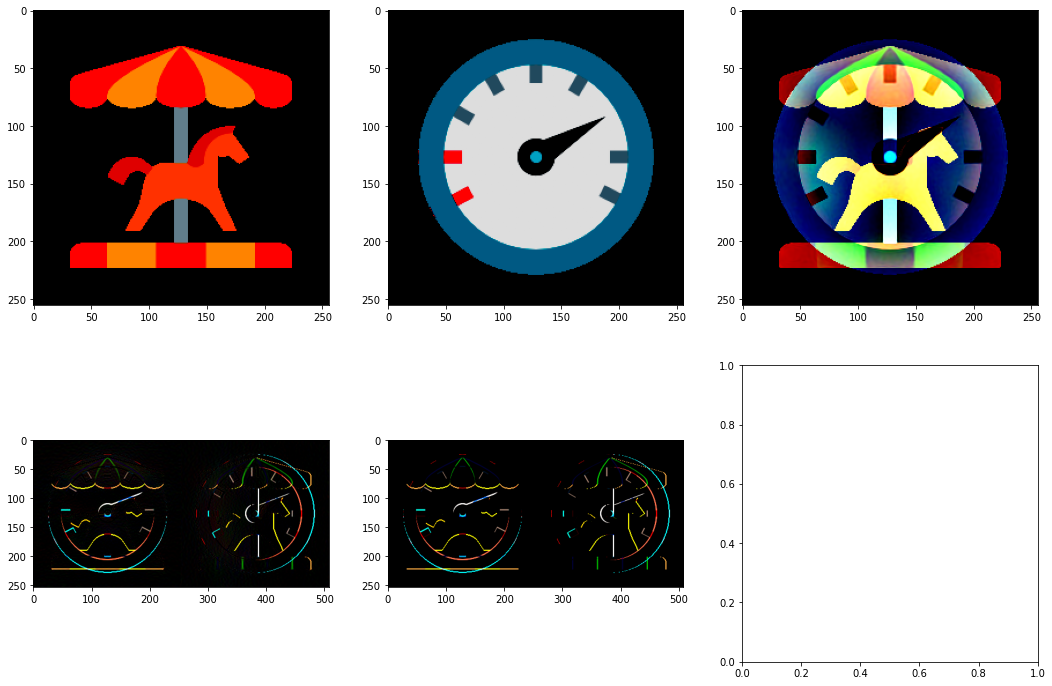

Step 300, Total loss 0.001088


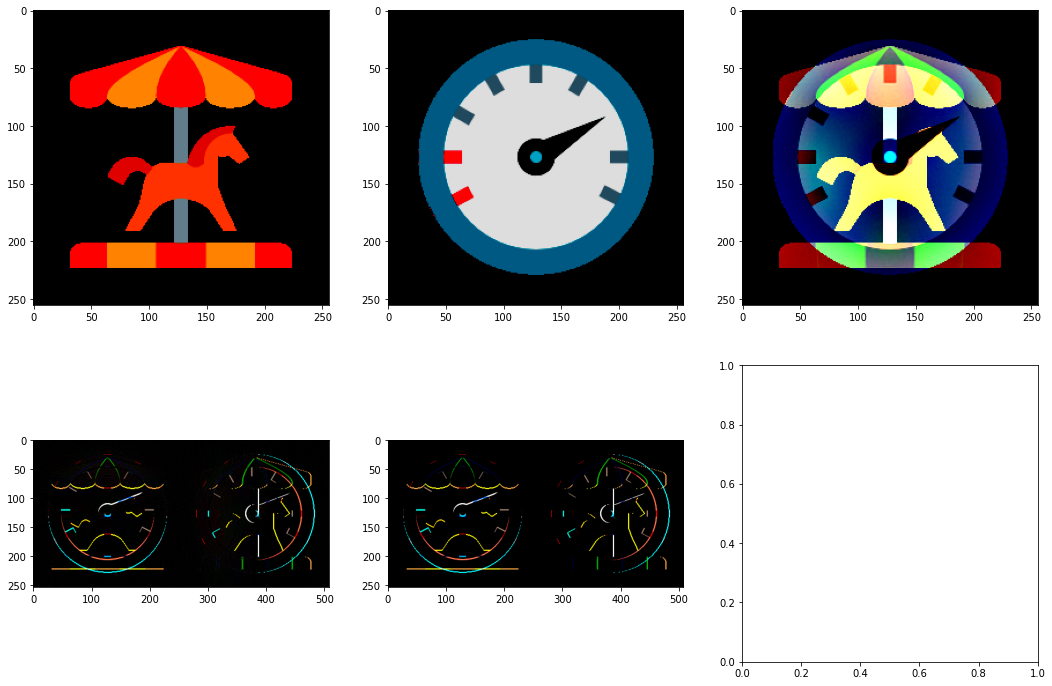

Step 400, Total loss 0.000547


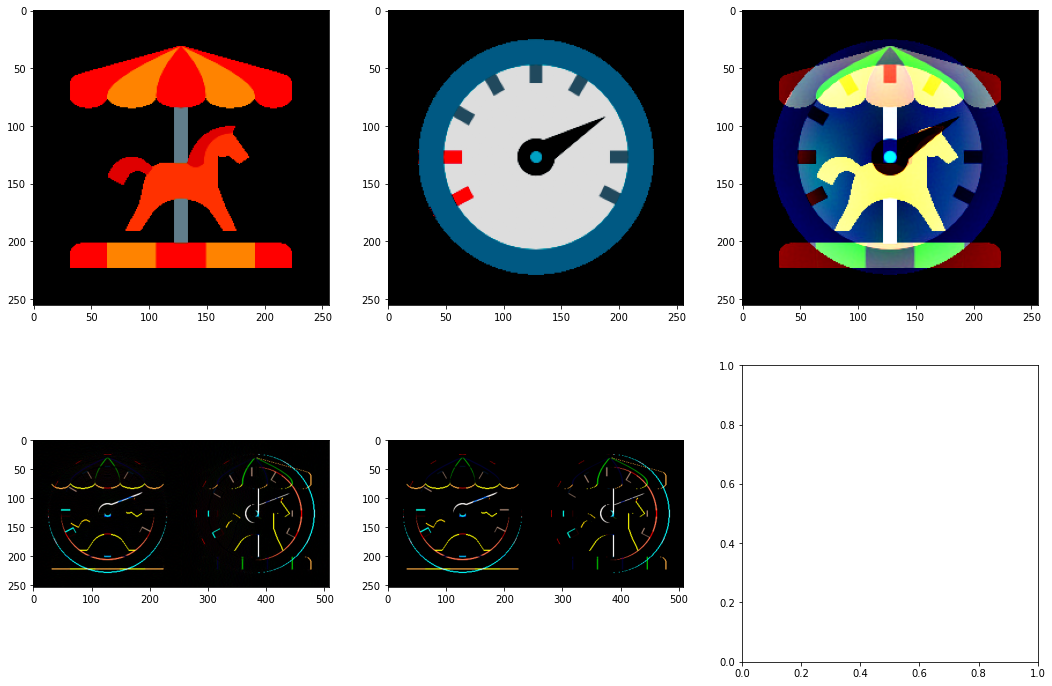

Step 500, Total loss 0.000341


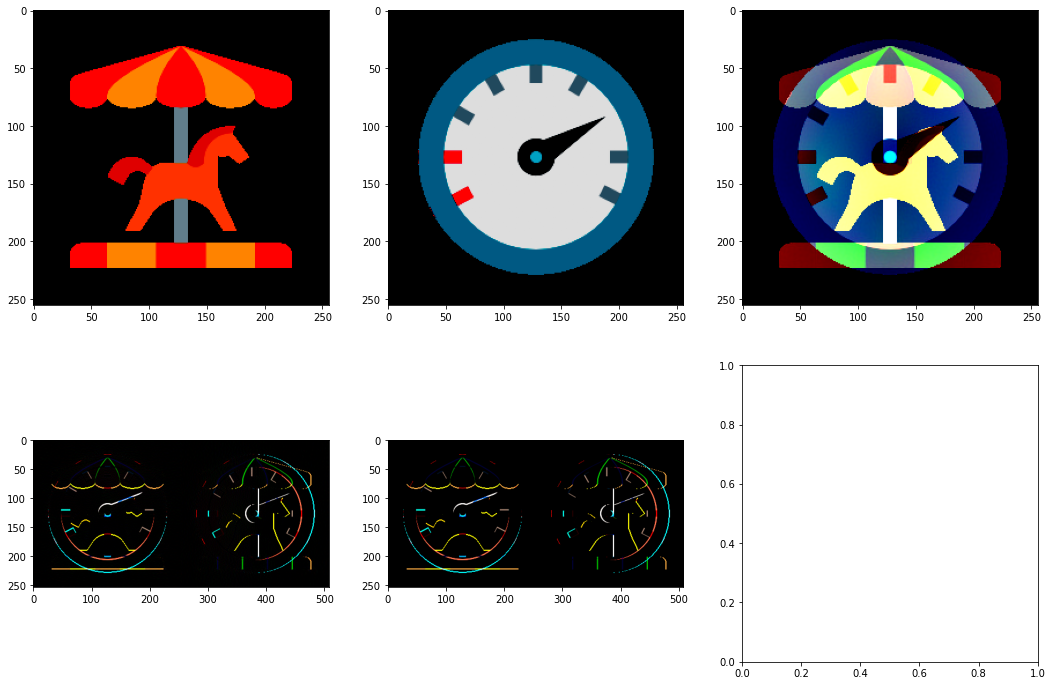

In [34]:
mix_image_pair(12, 24, total_steps=501, steps_til_summary=100)

Step 100, Total loss 0.003464


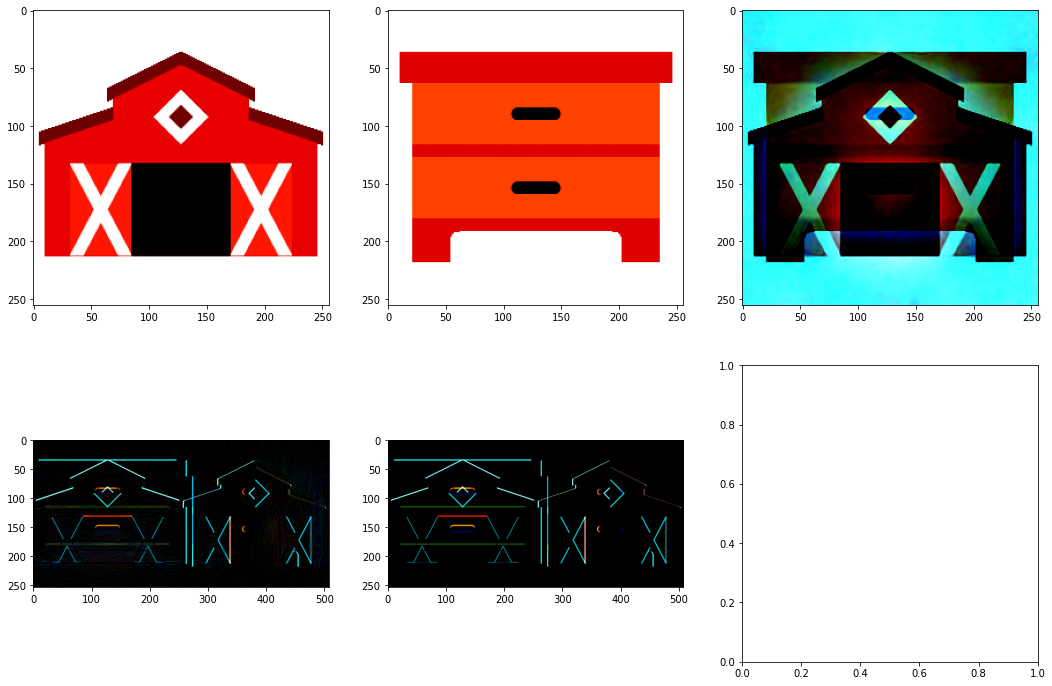

Step 200, Total loss 0.000841


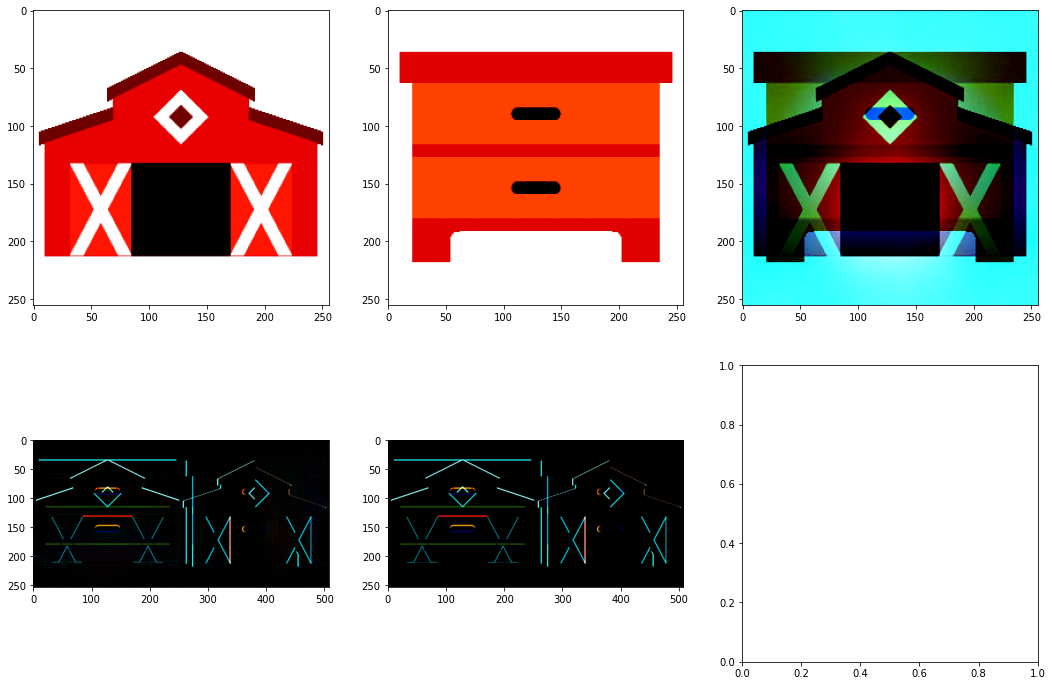

Step 300, Total loss 0.000364


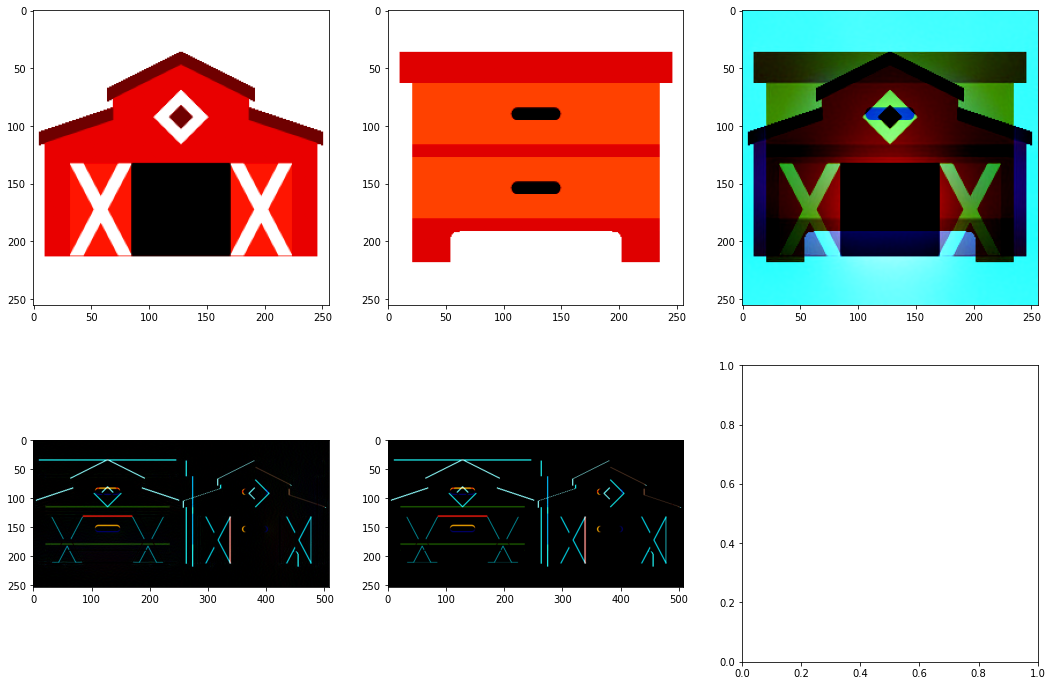

Step 400, Total loss 0.000262


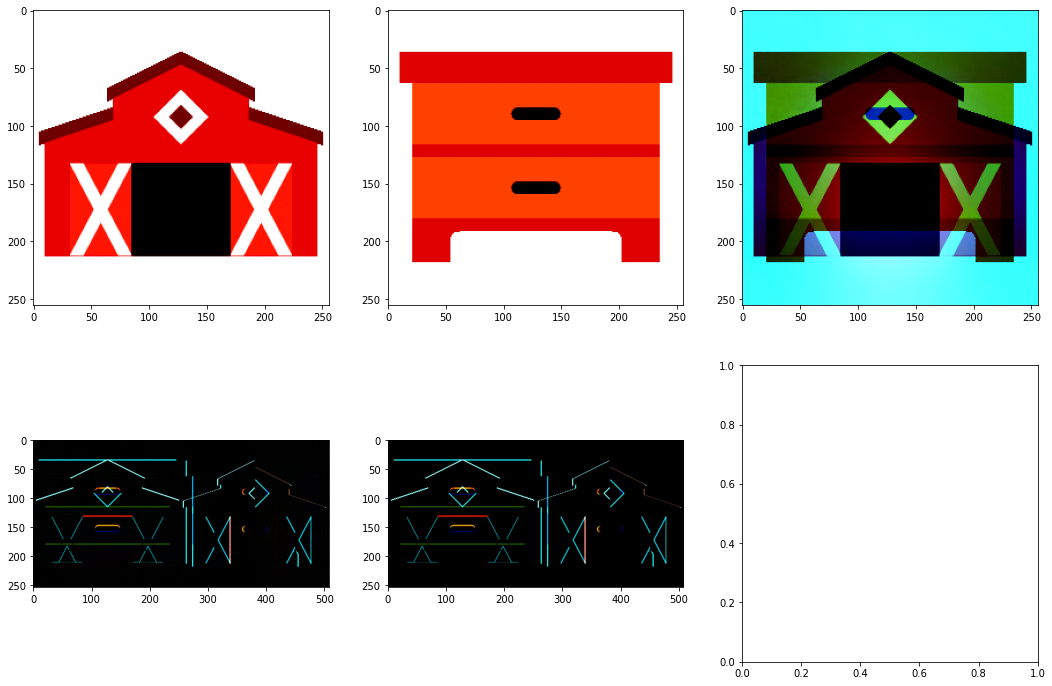

Step 500, Total loss 0.000118


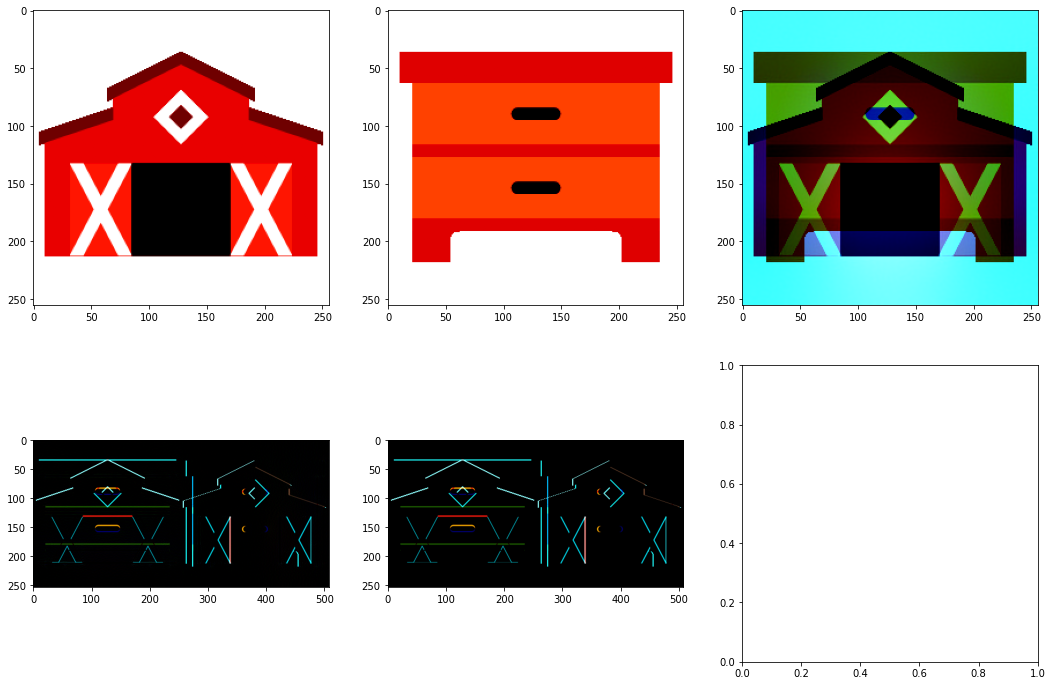

In [35]:
mix_image_pair(3, 7, total_steps=501, steps_til_summary=100)

# Question 2(iv): Shortcomings

As shown by the displayed examples, the interpolated image sometimes contains regions with very different colors than both the source images. The main reason is that the minimized loss function considers just the similarity between the gradient maps, but ignores other image features such as intensity or color distribution. Since the "ground truth" gradient map was not created from an existing image, but by summing the gradient maps of two different images, the generated image might split regions which were flat in both images, and fill them by new colors that do not appear in any input image, just for "reconstructing" the contrast in the split regions.

Another limitation is that the generated image content is uncontrolled. For a certain region the generated image might contain a color or texture from one image, and it is unclear how (or if) can it be forced to prefer the content of the selected image and not the other one. It is also unclear how to make the color or texture of a region in the generated image consistent with other  image regions, in case that they had similar color or texture in the source images.


# Question 3: Improved Image Interpolation

An improved image interpolation might be acheived by considering not only contrast (gradients) but also additional image features such as color and local texture. Also, more consistent and "convincing" (or "natural") interpolation might be provided while considering the image representation in multiple resolutions.

Therefore, I suggest to expand the method described in Question 2(b) as follows:

1. **Consider more detailed texture.** Use a featue map which contains not only of $dx$ and $dy$, but also local texture descriptors such as histograms of gradients (HOGs). In other words, instead of minimizing the squared distance between gradient maps with two channels, minimize it between texture maps with $k >> 2$ channels. 

2. **Consider intensity and/or color.** Add to the loss function terms which are related to the average intensity and/or the boundary RGB values:
  * Minimize the absolute difference between the image intensities $| mean(f_{SIREN}(x)) - \frac{1}{2}(mean(f_1(x) + f_2(x)) |$.
  * Alternatively, minimize the mean suqared error over the iamge boundary RGB values (as was done in classic poisson image editing). 
  * Another term to minimize might be the $KL$ divergence between the color distribution (=normalized histogram) of the generated image and those of the source images (i.e., the average of their color distributions).

3. **Use a multi-resolution representation.** Downsample the pair of input images $L$ times, and compute their gradient maps in each resolution. Then combine them in the same way in all levels (e.g. sum them) and get multi-resolution gradient maps $\{\nabla f^l_{GT}(x)\}_{l=1}^L$. Given the generated image $F_{SIREN}(x)$, downsample it $L$ times and compute the gradient maps in all these resolutions. Then minimize the multi-resolution loss function $\Sigma_{l=1}^L { MSE(\nabla f^l_{SIREN}(x) , \nabla f^l_{GT}(x)) }$ .
